In [1]:
# First, install the correct version of MediaPipe
!pip uninstall -y mediapipe  # Remove any existing version
!pip install mediapipe==0.10.21

Found existing installation: mediapipe 0.10.21
Uninstalling mediapipe-0.10.21:
  Successfully uninstalled mediapipe-0.10.21
  Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl (35.6 MB)


In [2]:
import cv2
import numpy as np
from mediapipe.python.solutions import selfie_segmentation
from google.colab.patches import cv2_imshow

In [3]:
# Load image (make sure 'first_image.jpg' is uploaded)
img = cv2.imread("first_image.jpg")
if img is None:
    raise FileNotFoundError("Image not found! Please upload it first.")

In [4]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [5]:
# Ensure the image is contiguous in memory (fixes MediaPipe error)
img_rgb = np.ascontiguousarray(img_rgb)


In [6]:
# Selfie segmentation (model_selection=1 for general scenes)
with selfie_segmentation.SelfieSegmentation(model_selection=1) as seg_model:
    results = seg_model.process(img_rgb)

In [7]:
# Create mask (1=person, 0=background)
mask = (results.segmentation_mask > 0.5).astype(np.uint8) * 255

In [8]:
# Find the largest connected person (main subject)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
if num_labels > 1:  # If at least one person found
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    main_person_mask = (labels == largest_label).astype(np.uint8) * 255
else:
    main_person_mask = np.zeros_like(mask)  # No person found

In [9]:
# Blur the entire background (including other people)
blurred = cv2.GaussianBlur(img, (51, 51), 0)

In [10]:
# Keep only main person sharp, blur everything else
final_img = np.where(
    cv2.merge([main_person_mask] * 3) == 255,
    img,      # Keep main person sharp
    blurred   # Blur everything else
)

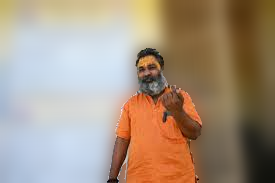

In [11]:
# Display result
cv2_imshow(final_img)